## Jupyter Notebook: Gradient Boosting Example - Diabetes Prediction

**Goal:** Predict whether a patient has diabetes based on diagnostic measurements using the Gradient Boosting Classifier.

**Gradient Boosting Intuition:** Gradient Boosting builds an ensemble of decision trees sequentially, with each new tree focusing on correcting the errors made by the previous ones. It's a powerful algorithm often used for classification and regression tasks due to its high accuracy potential.

---

### 1. Import Libraries

In [3]:
# Core libraries
import pandas as pd
import numpy as np

# Dataset loading (from OpenML) and splitting
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Gradient Boosting Classifier model
from sklearn.ensemble import GradientBoostingClassifier

# Evaluation metrics for classification
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             classification_report,
                             roc_curve, # For ROC curve
                             auc,       # For Area Under Curve (AUC)
                             ConfusionMatrixDisplay)

# Optional: Scaler if needed (though less critical for GBT)
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

print("Libraries imported successfully!")

Libraries imported successfully!


---

### 2. Load and Explore the Dataset

We'll load the Pima Indians Diabetes dataset from OpenML using scikit-learn's `Workspace_openml`.

In [4]:
# Load the dataset from OpenML
# Note: fetch_openml might require an internet connection the first time
print("Loading Pima Indians Diabetes dataset from OpenML...")
try:
    # Use parser='liac-arff' if loading fails with default parser
    diabetes = fetch_openml(name='diabetes', version=1, as_frame=True, parser='auto')
    diabetes_df = diabetes.frame
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please check your internet connection or try setting parser='liac-arff'.")
    # As a fallback, create a dummy dataframe to avoid downstream errors
    # In a real scenario, you would troubleshoot the loading issue.
    diabetes_df = pd.DataFrame() # Empty DataFrame

if not diabetes_df.empty:
    # Display first few rows
    print("\nFirst 5 rows of the Diabetes dataset:")
    print(diabetes_df.head())

    # Display basic info
    print("\nDataset Info:")
    diabetes_df.info()

    # The target variable is 'class', often loaded as categorical/object. Convert it.
    # Check unique values in target
    print("\nTarget variable ('class') unique values:", diabetes_df['class'].unique())
    # Convert target 'class' to numeric (0 for 'tested_negative', 1 for 'tested_positive')
    diabetes_df['class'] = diabetes_df['class'].cat.codes # Converts based on category order

    # Display summary statistics
    print("\nSummary Statistics:")
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        print(diabetes_df.describe())

    # Check class distribution (imbalance?)
    print("\nClass Distribution (0: Negative, 1: Positive):")
    print(diabetes_df['class'].value_counts(normalize=True)) # normalize=True shows percentage

    # *** Data Quality Check ***
    # Many datasets use 0 for missing values in columns where 0 is biologically impossible
    # 'Glucose' → 'plas'
    # 'BloodPressure' → 'pres'
    # 'SkinThickness' → 'skin'
    # 'Insulin' → 'insu'
    # 'BMI' → 'mass'
    print("\nChecking for suspicious zero values:")
    cols_to_check = ['plas', 'pres', 'skin', 'insu', 'mass']
    print((diabetes_df[cols_to_check] == 0).sum())
    # Note: For a production model, these zeros should ideally be treated as missing data
    # (e.g., replaced with NaN and imputed). For this example's simplicity, we proceed
    # acknowledging this limitation, which might affect model performance.

Loading Pima Indians Diabetes dataset from OpenML...
Dataset loaded successfully.

First 5 rows of the Diabetes dataset:
   preg  plas  pres  skin  insu  mass   pedi  age            class
0     6   148    72    35     0  33.6  0.627   50  tested_positive
1     1    85    66    29     0  26.6  0.351   31  tested_negative
2     8   183    64     0     0  23.3  0.672   32  tested_positive
3     1    89    66    23    94  28.1  0.167   21  tested_negative
4     0   137    40    35   168  43.1  2.288   33  tested_positive

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   preg    768 non-null    int64   
 1   plas    768 non-null    int64   
 2   pres    768 non-null    int64   
 3   skin    768 non-null    int64   
 4   insu    768 non-null    int64   
 5   mass    768 non-null    float64 
 6   pedi    768 non-null    float64 
 7   age     768

*Observation:* The dataset has 768 samples and 8 features plus the target class. There's a class imbalance (more non-diabetic cases). Importantly, several columns contain zero values where they are biologically implausible, suggesting they might represent missing data. Proper handling (imputation) would be best practice, but we'll proceed for now to focus on the Gradient Boosting steps.

---

### 3. Prepare Data for Modeling

Separate features and target, then split.

In [5]:
if not diabetes_df.empty:
    # Features (all columns except the target 'class')
    X = diabetes_df.drop('class', axis=1)

    # Target variable (already converted to 0/1)
    y = diabetes_df['class']

    # Split data into training and testing sets (e.g., 75% train, 25% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    # stratify helps maintain class proportion in splits, important for imbalanced data

    print(f"\nTraining set shape: X_train={X_train.shape}, y_train={y_train.shape}")
    print(f"Testing set shape:  X_test={X_test.shape}, y_test={y_test.shape}")
else:
    print("\nSkipping data preparation as dataset loading failed.")
    # Assign dummy empty arrays to avoid errors in subsequent cells if needed for demo structure
    X_train, X_test, y_train, y_test = np.array([]), np.array([]), np.array([]), np.array([])


Training set shape: X_train=(576, 8), y_train=(576,)
Testing set shape:  X_test=(192, 8), y_test=(192,)


---

### 4. Build and Train the Gradient Boosting Model

Instantiate and train `GradientBoostingClassifier`.

In [6]:
if X_train.size > 0: # Proceed only if data was loaded and split
    # Create the Gradient Boosting Classifier instance
    gbc = GradientBoostingClassifier(n_estimators=100,
                                   learning_rate=0.1,
                                   max_depth=3,
                                   subsample=0.8, # Use 80% of data for fitting each tree (Stochastic GB)
                                   random_state=42)

    # Train the model
    print("Training Gradient Boosting Classifier model...")
    gbc.fit(X_train, y_train)
    print("Model training complete.")
else:
    print("\nSkipping model training as data is not available.")
    gbc = None # Set model to None

Training Gradient Boosting Classifier model...
Model training complete.
Model training complete.


---

### 5. Make Predictions

Predict both class labels and probabilities for the test set. Probabilities are useful for metrics like AUC and for adjusting the decision threshold if needed.

In [7]:
if gbc: # Proceed only if model was trained
    # Predict class labels (0 or 1)
    y_pred = gbc.predict(X_test)

    # Predict probabilities for each class (col 0: prob of class 0, col 1: prob of class 1)
    y_pred_proba = gbc.predict_proba(X_test)[:, 1] # Keep only probability for the positive class (class 1)

    print("\nSample Predictions vs Actual Labels:")
    comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Prob_Positive': y_pred_proba})
    print(comparison.head(10))
else:
    print("\nSkipping predictions as model was not trained.")
    y_pred = np.array([])
    y_pred_proba = np.array([])


Sample Predictions vs Actual Labels:
     Actual  Predicted  Prob_Positive
635       1          0       0.288048
698       0          0       0.349073
637       0          0       0.082689
402       1          0       0.201092
425       1          1       0.888371
653       0          0       0.086741
351       0          0       0.389697
537       0          0       0.054328
44        0          1       0.780722
203       0          0       0.023805


---

### 6. Evaluate the Model

Evaluate using various classification metrics, including the ROC curve and AUC, which are particularly useful for binary classification, especially with imbalance.


Model Accuracy: 0.7292

Classification Report:
              precision    recall  f1-score   support

    Negative       0.77      0.83      0.80       125
    Positive       0.63      0.54      0.58        67

    accuracy                           0.73       192
   macro avg       0.70      0.68      0.69       192
weighted avg       0.72      0.73      0.72       192


Confusion Matrix:


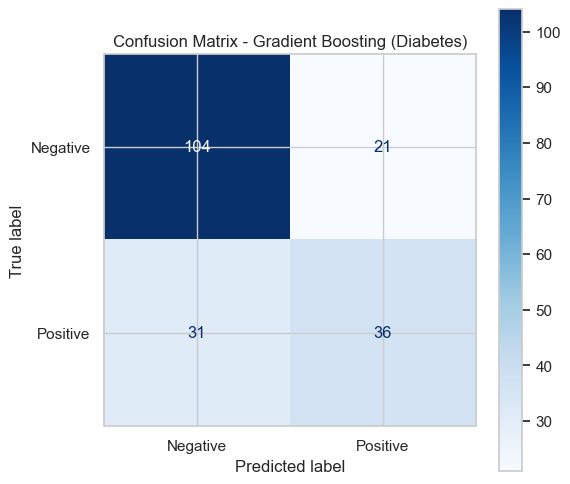


Area Under ROC Curve (AUC): 0.8025


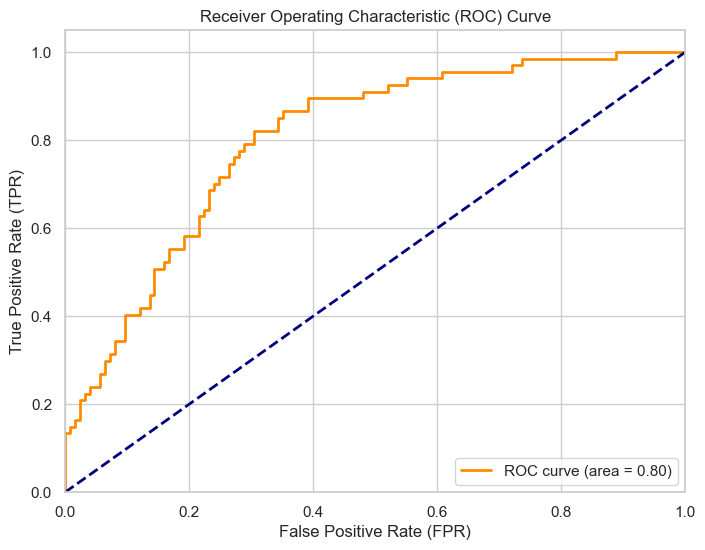

In [8]:
if y_pred.size > 0: # Proceed only if predictions were made
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nModel Accuracy: {accuracy:.4f}")

    # Generate the Classification Report
    print("\nClassification Report:")
    # Use target names based on the conversion: 0 -> 'tested_negative', 1 -> 'tested_positive'
    target_names_map = {0: 'Negative', 1: 'Positive'}
    report = classification_report(y_test, y_pred, target_names=target_names_map.values())
    print(report)

    # Generate and Visualize the Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names_map.values())
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap='Blues', ax=ax)
    plt.title('Confusion Matrix - Gradient Boosting (Diabetes)')
    plt.show()

    # Calculate ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) # Use probabilities for ROC
    roc_auc = auc(fpr, tpr)
    print(f"\nArea Under ROC Curve (AUC): {roc_auc:.4f}")

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Diagonal 50% line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

else:
    print("\nSkipping model evaluation as predictions are not available.")

*Interpretation:*
* **Accuracy:** Overall correctness.
* **Classification Report:** Check precision/recall/F1 for both 'Negative' and 'Positive' classes. Recall for the 'Positive' class (Sensitivity) is often important in medical diagnosis – how many actual diabetics did we correctly identify? Precision for 'Positive' indicates how many predicted as diabetic actually were.
* **Confusion Matrix:** Visualize the trade-offs (True Positives, False Positives, True Negatives, False Negatives).
* **AUC:** Area Under the ROC Curve. Represents the model's ability to distinguish between the positive and negative classes across all possible thresholds. An AUC of 0.5 is random guessing, while 1.0 is perfect separation. A value > 0.7 is generally considered acceptable, > 0.8 good, > 0.9 excellent.

---

### 7. Feature Importance

Examine which diagnostic features were most influential.

C:\Users\abhij\AppData\Local\Temp\ipykernel_9988\312925683.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


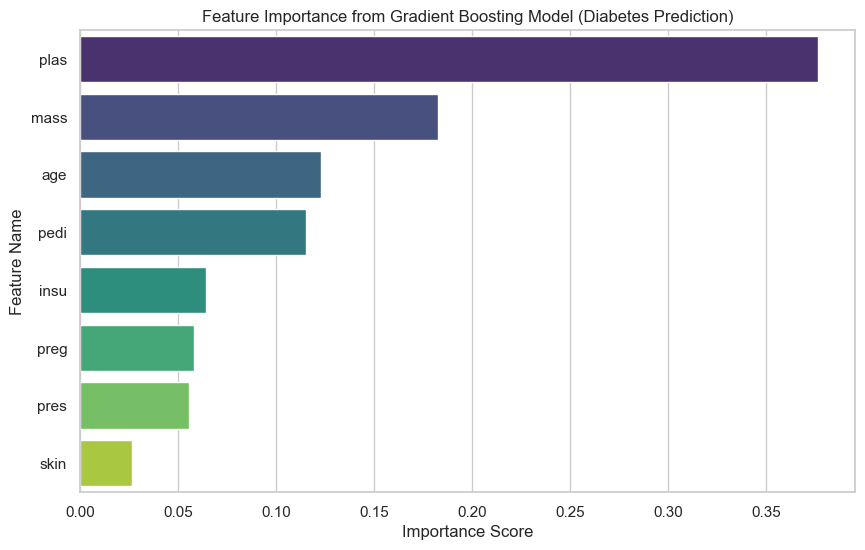


Feature Importances (Top features first):
  Feature  Importance
1    plas    0.376596
5    mass    0.182480
7     age    0.122622
6    pedi    0.114934
4    insu    0.064006
0    preg    0.057846
2    pres    0.055373
3    skin    0.026142


In [9]:
if gbc: # Proceed only if model was trained
    # Get feature importances
    importances = gbc.feature_importances_
    feature_names = X.columns # Get feature names from the DataFrame

    # Create a DataFrame for visualization
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title('Feature Importance from Gradient Boosting Model (Diabetes Prediction)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature Name')
    plt.show()

    print("\nFeature Importances (Top features first):")
    print(feature_importance_df)
else:
    print("\nSkipping feature importance as model was not trained.")

*Observation:* This plot shows which features (like Glucose, BMI, Age, Insulin etc.) the model found most predictive of diabetes onset in this dataset. Glucose level is often the most significant predictor.

---

### 8. Conclusion

We applied the Gradient Boosting Classifier to the Pima Indians Diabetes dataset to predict diabetes onset. The process included loading data via `Workspace_openml`, preparing features and target, training the model, and evaluating using accuracy, confusion matrix, classification report, and AUC-ROC curve. We also visualized feature importances.

The model demonstrated reasonable performance (typical AUC for GBT on this dataset is often in the 0.80-0.85 range, depending on parameters and handling of zeros). We noted the potential data quality issue with zero values in certain columns, which ideally should be addressed through imputation for a more robust analysis. Gradient Boosting remains a strong choice for such binary classification tasks, but like all models, data quality and hyperparameter tuning are key to achieving optimal results.